# Topic: Cadence!

Question: What cadences should I am for in specific paces? I've decided on aiming for a 3:25 time to ensure that I can register. Garmin reports run cadence as a metric.

**Method**
1. Analyze track run intervals...and posssibly all other runs
2. plot cadence by pace, cadence by altitude 
3. If linear relationship, good candidate for logistic regression

Tie back to terrain of the qualifying race, Avenue of the Giants.

In [227]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tcxparser 
import sys
import os
import numpy as np
bq_path = '/Users/aishaellahi/py2/bq'
sys.path.append(bq_path)
import bq

In [228]:
reload(bq)

<module 'bq' from '/Users/aishaellahi/py2/bq/bq.pyc'>

In [229]:
tcx_file_path = '/Users/aishaellahi/py2/bq/tcx'
df_list = []
for tcx_file in os.listdir(tcx_file_path):
    if tcx_file.find('marathon') !=-1:
        pass
    else:
        tcx_file = '/'.join([tcx_file_path,tcx_file])
        #print('Parsing %s...') %tcx_file
        test = bq.parse_lap_metrics(tcx_file)
        df = pd.DataFrame(test)
        df.sort_values(by='lap_start', inplace=True)
        df['lap_start'] = pd.to_datetime(df['lap_start'])
        index_list = []
        for n, row in df.iterrows():
            lapstart = row['lap_start'].strftime('%Y-%m-%d')
            lap_num = str(n+1)
            i = '_'.join([lap_num, lapstart])
            index_list.append(i)
        df['lap_index'] = pd.Series(index_list)
        df_list.append(df)

In [230]:
all_data = pd.concat(df_list)
print(all_data.shape)

(217, 11)


In [231]:
all_data.rename(columns={'average_cadence':'half_cadence'}, inplace=True)

In [232]:
# data prepping...
all_data['miles'] = all_data['meters'].apply(bq.meters_to_miles)
all_data['minutes'] = all_data['seconds'].apply(bq.seconds_to_minutes)
all_data['pace'] = all_data['minutes']/all_data['miles']
all_data['average_cadence'] = all_data['half_cadence']*2
all_data['altitude_change'] = all_data['start_altitude'] - all_data['end_altitude']
all_data.sort_values(by='lap_start', inplace=True)
all_data.set_index('lap_index', inplace=True)
all_data.head(2)

,half_cadence,end_altitude,end_meters,lap_start,meters,run_start,run_type,seconds,start_altitude,start_meters,miles,minutes,pace,average_cadence,altitude_change
lap_index,,,,,,,,,,,,,,,
1_2017-09-27,92.0,NaN,1610.689941,2017-09-27 12:12:00,1609.34,2017-09-27T12:12:00.000Z,tempo,608.0,NaN,0.000000,0.999998,10.133333,10.133359,184.0,NaN
2_2017-09-27,94.0,83.800003,3221.219971,2017-09-27 12:22:13,1609.34,2017-09-27T12:12:00.000Z,tempo,530.0,58.799999,1631.459961,0.999998,8.833333,8.833355,188.0,-25.000004


In [233]:
all_data['pace'] = all_data['pace'].astype(float)
all_data['average_cadence'] = all_data['average_cadence'].astype(float)

In [94]:
# Throw out weird outliers...
ind_to_drop = all_data.loc[((all_data['pace'] > 10) | (all_data['pace'] < 5))].index.tolist()
print(ind_to_drop)
print(len(ind_to_drop))
print(len(set(ind_to_drop)))
all_data.drop(ind_to_drop, inplace=True)

[]
0
0


In [121]:
# Drop all cadences below 170
to_drop = all_data.loc[(all_data['average_cadence'] <= 170) | (all_data['miles'] < 0.25)].index.tolist()
print(len(to_drop))
all_data.drop(to_drop, inplace=True)

8


In [122]:
print(all_data.shape)

(133, 14)


In [146]:
from scipy.stats import linregress



def predicted_pace(x_val):
    m, i, r, pval, stderr = linregress(all_data['average_cadence'], all_data['pace'])
    y = m*x_val + i 
    return y


x_vals = pd.Series(np.arange(177, 206))
predicted_ys = x_vals.apply(predicted_pace)

In [159]:
m, i, r, pval, stderr = linregress(all_data['average_cadence'], all_data['pace'])
print('slope: %s') %str(m)
print('R-value: %s') %str(r)

slope: -0.0711858970061
R-value: -0.438292564591


In [205]:
run_type_filter = ['track']
filtered_df = all_data.loc[all_data['run_type'].isin(run_type_filter)]

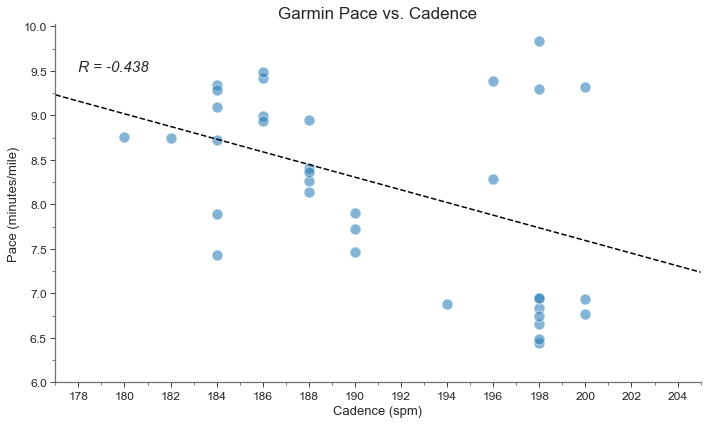

In [206]:
# Test plot!
from matplotlib.ticker import MultipleLocator 

sns.set_style('white')
plt.rcParams['figure.figsize'] = (10,6)
# salmon pink '#F5488F'
plt.scatter(filtered_df['average_cadence'], filtered_df['pace'], alpha=0.55, edgecolor='white',
           s=120)
plt.plot(x_vals, predicted_ys, c='black', lw=1.5, linestyle='--')
plt.xticks(np.arange(178, 206, 2), size=12)
plt.yticks(np.arange(6, 10.5, 0.5), size=12)

# set minor ticks
mlx = MultipleLocator(1)
plt.gca().axes.xaxis.set_minor_locator(mlx)
plt.gca().axes.tick_params(axis='x', size=5, right='off', which='major')
plt.gca().axes.tick_params(axis='x', size=3, right='off', which='minor')

mly = MultipleLocator(0.25)
plt.gca().axes.yaxis.set_minor_locator(mly)
plt.gca().axes.tick_params(axis='y', size=5, right='off', which='major')
plt.gca().axes.tick_params(axis='y', size=3, right='off', which='minor')

# Format spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_color('#766D71')
plt.gca().spines['bottom'].set_color('#766D71')
#plt.gca().spines['left'].linewidth = 3
#plt.scatter(8.2, color='gray', linestyle='--', lw=1.5)
plt.text(178, 9.5, 'R = -0.438', fontsize=15, style='oblique')
plt.xlim(177, 205)
plt.title("Garmin Pace vs. Cadence", size=17)
plt.ylabel('Pace (minutes/mile)', size=13)
plt.xlabel('Cadence (spm)', size=13)
plt.tight_layout()
#plt.savefig('garmin_default_pace_vs_cadence.png')

In [198]:
import collections
collections.Counter(all_data['run_type'])

Counter({'long': 30, 'tempo': 68, 'track': 35})

In [192]:
# tempo: 7.45 for 3:35 marathon time
# speed: 7.0 for 3:35 marathon time

# tempo: 
# speed:

0.45

In [222]:
test_cadences = np.arange(180, 206, 4)
print len(test_cadences)
test_cadences

7


array([180, 184, 188, 192, 196, 200, 204])

In [118]:
cols_to_show = ['run_type', 'meters', 'seconds', 'miles', 'minutes']
sorted_data = all_data.sort_values(by='miles')
sorted_data[cols_to_show].head(10)

,run_type,meters,seconds,miles,minutes
lap_index,,,,,
7_2017-10-14,track,24.20,6.0,0.015037,0.100000
4_2017-10-14,track,26.86,8.0,0.016690,0.133333
10_2017-10-14,track,58.30,12.0,0.036226,0.200000
6_2017-10-20,tempo,202.48,58.0,0.125815,0.966667
12_2017-10-06,track,247.85,86.0,0.154007,1.433333
4_2017-10-06,track,271.24,87.0,0.168541,1.450000
14_2017-10-06,track,295.54,87.0,0.183640,1.450000
4_2017-10-27,tempo,382.64,116.0,0.237761,1.933333
1_2017-10-20,track,409.86,118.0,0.254675,1.966667


In [214]:
from scipy.stats import variation

# Bin intervals by interval distance
all_data['distance_bin'] = pd.cut(all_data['miles'], bins=np.arange(0, 1.1, 0.25))
grouped = all_data[['average_cadence', 
                    'distance_bin', 
                    'pace']].groupby(['average_cadence', 
                                    'distance_bin']).aggregate(['count', 
                                                                np.mean,
                                                                np.std,
                                                                variation])
grouped

pace                              
                             count      mean       std variation
average_cadence distance_bin                                    
180.0           (0.25, 0.5]      1  8.759580       NaN  0.000000
182.0           (0.25, 0.5]      1  8.744558       NaN  0.000000
184.0           (0.25, 0.5]      2  7.661486  0.324496  0.029949
                (0.5, 0.75]      1  9.092495       NaN  0.000000
                (0.75, 1.0]      9  8.808297  0.545550  0.058394
186.0           (0.25, 0.5]      3  8.842147  0.213276  0.019694
                (0.75, 1.0]     23  8.550746  0.445814  0.050991
188.0           (0.25, 0.5]      1  7.691565       NaN  0.000000
                (0.5, 0.75]      2  8.318127  0.564860  0.048018
                (0.75, 1.0]     23  8.433276  0.459886  0.053334
190.0           (0.25, 0.5]      2  7.810350  0.124585  0.011279
                (0.5, 0.75]      2  7.662979  0.279162  0.025760
                (0.75, 1.0]     23  8.470723  0.476590  0.055026
192.0           (0.75, 1.0]     12  8.561132  0.336826  0.037669
194.0           (0.25, 0.5]      1  6.874413       NaN  0.000000
                (0.75, 1.0]      6  8.086131  0.720296  0.081317
196.0           (0.25, 0.5]      1  8.281416       NaN  0.000000
                (0.75, 1.0]      5  8.223354  0.692682  0.075341
198.0           (0.25, 0.5]      2  6.638544  0.284495  0.030303
                (0.5, 0.75]      4  7.338181  1.315529  0.155254
                (0.75, 1.0]      4  7.620345  1.478321  0.168006
200.0           (0.25, 0.5]      3  7.677912  1.425236  0.151565

In [223]:
# explore the data

#sns.distplot(all_data['average_cadence'], kde=False, bins=np.arange(165, 203, 1))
#sns.jointplot(all_data['average_cadence'], all_data['pace'], kind='hex')

## 2017-11-05 The Grand Cadence Experiment

In [242]:
all_data['miles'] = all_data['miles'].round(1)

In [293]:
# filter out "Grand Experiment Data"
cadence_exp_ind = ['1_2017-11-05',
 '2_2017-11-05',
 '3_2017-11-05',
 '4_2017-11-05',
 '5_2017-11-05',
 '6_2017-11-05',
 '7_2017-11-05',
 '8_2017-11-05',
 '9_2017-11-05',
 '10_2017-11-05',
 '11_2017-11-05',
 '12_2017-11-05',
 '13_2017-11-05',
 '14_2017-11-05',
 '15_2017-11-05',
 '16_2017-11-05',
 '17_2017-11-05',
 '18_2017-11-05',
 '19_2017-11-05',
 '20_2017-11-05',
 '21_2017-11-05',
 '22_2017-11-05',
 '23_2017-11-05',
 '24_2017-11-05',
 '25_2017-11-05',
 '26_2017-11-05',
 '27_2017-11-05',
 '28_2017-11-05',
 '29_2017-11-05',
 '30_2017-11-05',
 '31_2017-11-05',
 '32_2017-11-05',
 '33_2017-11-05',
 '34_2017-11-05',
 '35_2017-11-05',
 '36_2017-11-05']
cadence_experiment = all_data.loc[cadence_exp_ind].copy()

In [294]:
cadence_experiment.shape

(36, 15)

In [295]:
# Columns to add once I pull out actual intervals: 
# target cadence: 
cadence_exp_intervals = cadence_experiment.loc[cadence_experiment['miles']==0.5]
cadence_exp_intervals.shape

(16, 15)

In [296]:
#cadence_exp_intervals.reset_index(inplace=True)
test_cadences = np.arange(180, 210, 4)
cadence_exp_intervals['target_cadence'] = pd.Series(np.repeat(test_cadences, 2))
# mark replicates
rep = [1, 2]*16
cadence_exp_intervals['replicate'] = pd.Series(rep)
collections.Counter(cadence_exp_intervals['target_cadence'])

/Users/aishaellahi/.pyenv/versions/2.7.12/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/aishaellahi/.pyenv/versions/2.7.12/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Counter({180: 2, 184: 2, 188: 2, 192: 2, 196: 2, 200: 2, 204: 2, 208: 2})

In [297]:
cadence_exp_intervals.tail()

,lap_index,half_cadence,end_altitude,end_meters,lap_start,meters,run_start,run_type,seconds,start_altitude,start_meters,miles,minutes,pace,average_cadence,altitude_change,target_cadence,replicate
11,26_2017-11-05,99.0,2.8,15332.889648,2017-11-05 18:27:16,804.67,2017-11-05T17:05:31.000Z,long,218.0,1.4,14549.530273,0.5,3.633333,7.266685,198.0,-1.4,200,2
12,28_2017-11-05,98.0,1.2,16264.980469,2017-11-05 18:31:57,804.67,2017-11-05T17:05:31.000Z,long,215.0,3.0,15482.150391,0.5,3.583333,7.166684,196.0,1.8,204,1
13,30_2017-11-05,99.0,1.8,17230.820312,2017-11-05 18:37:38,804.67,2017-11-05T17:05:31.000Z,long,216.0,1.2,16448.179688,0.5,3.600000,7.200018,198.0,-0.6,204,2
14,32_2017-11-05,98.0,1.6,18189.859375,2017-11-05 18:43:23,804.67,2017-11-05T17:05:31.000Z,long,367.0,2.8,17407.820312,0.5,6.116667,12.233364,196.0,1.2,208,1
15,34_2017-11-05,99.0,2.0,19164.349609,2017-11-05 18:50:33,804.67,2017-11-05T17:05:31.000Z,long,214.0,0.6,18382.490234,0.5,3.566667,7.133351,198.0,-1.4,208,2


In [298]:
# drop random outlier! (1 of the 208 cadence replicates)
cadence_exp_intervals.drop([14], inplace=True)

/Users/aishaellahi/.pyenv/versions/2.7.12/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


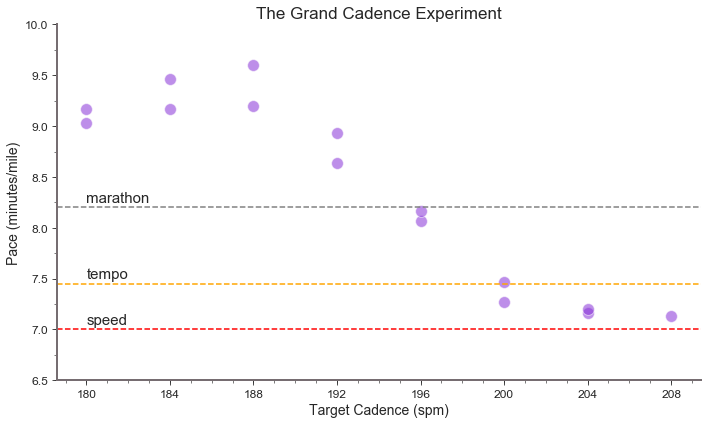

In [299]:
from matplotlib.ticker import MultipleLocator 

sns.set_style('white')
plt.rcParams['figure.figsize'] = (10,6)
# salmon pink '#F5488F'
# purple '#8731D7'

# plot data
plt.scatter(cadence_exp_intervals['target_cadence'], 
            cadence_exp_intervals['pace'], alpha=0.55, edgecolor='white',
           s=140, color='#8731D7')
# target speed
plt.axhline(7, lw=1.5, linestyle='--', color='red')
plt.text(180, 7.05, 'speed', fontsize=15)

# target tempo
plt.axhline(7.45, lw=1.5, linestyle='--', color='orange')
plt.text(180, 7.5, 'tempo', fontsize=15)


# target marathon pace
plt.axhline(8.2, lw=1.5, linestyle='--', color='gray')
plt.text(180, 8.25, 'marathon', fontsize=15)

# set tick locations
plt.xticks(np.arange(180, 210, 4), size=12)
plt.yticks(np.arange(6.5, 10.5, 0.5), size=12)

# set minor ticks
mlx = MultipleLocator(1)
plt.gca().axes.xaxis.set_minor_locator(mlx)
plt.gca().axes.tick_params(axis='x', size=5, right='off', which='major')
plt.gca().axes.tick_params(axis='x', size=3, right='off', which='minor')

mly = MultipleLocator(0.25)
plt.gca().axes.yaxis.set_minor_locator(mly)
plt.gca().axes.tick_params(axis='y', size=5, right='off', which='major')
plt.gca().axes.tick_params(axis='y', size=3, right='off', which='minor')

# Format spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_color('#766D71')
plt.gca().spines['left'].set_linewidth(2.0)
plt.gca().spines['bottom'].set_color('#766D71')
plt.gca().spines['bottom'].set_linewidth(2.0)

plt.title("The Grand Cadence Experiment", size=17)
plt.ylabel('Pace (minutes/mile)', size=14)
plt.xlabel('Target Cadence (spm)', size=14)
plt.tight_layout()
plt.savefig('cadence_experiment_pace_vs_cadence.png')

In [327]:
# assign colors to replicates
rep_color_map = {1:'#AC210B', 2:'#2E54EF'}
cadence_exp_intervals['rep_color'] = cadence_exp_intervals['replicate'].map(rep_color_map)

/Users/aishaellahi/.pyenv/versions/2.7.12/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [328]:
cadence_exp_intervals[['lap_index', 'replicate', 'rep_color']].head(2)

,lap_index,replicate,rep_color
0,4_2017-11-05,1,#AC210B
1,6_2017-11-05,2,#2E54EF


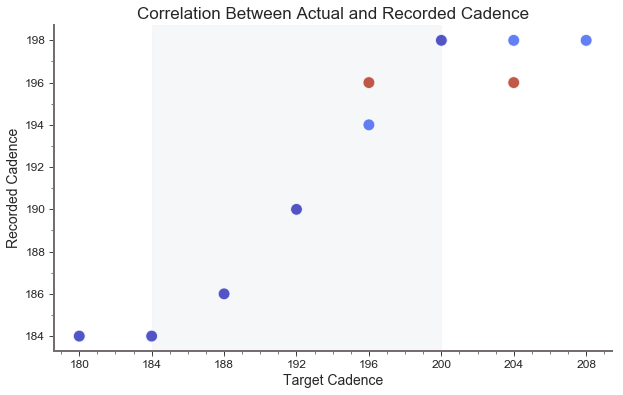

In [334]:
# Correlation between target and recorded average cadence
plt.scatter(cadence_exp_intervals['target_cadence'], 
            cadence_exp_intervals['average_cadence'], alpha=0.75, edgecolor='white',
           s=140, c=cadence_exp_intervals['rep_color'])

# Vertical fill between
plt.axvspan(184, 200, alpha=0.5, color='#EFF0F5', zorder=-1)

# set tick locations
plt.xticks(np.arange(180, 210, 4), size=12)
plt.yticks(np.arange(184, 200, 2), size=12)

# set minor ticks
mlx = MultipleLocator(1)
plt.gca().axes.xaxis.set_minor_locator(mlx)
plt.gca().axes.tick_params(axis='x', size=5, right='off', which='major')
plt.gca().axes.tick_params(axis='x', size=3, right='off', which='minor')

mly = MultipleLocator(1)
plt.gca().axes.yaxis.set_minor_locator(mly)
plt.gca().axes.tick_params(axis='y', size=5, right='off', which='major')
plt.gca().axes.tick_params(axis='y', size=3, right='off', which='minor')

# Format spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_color('#766D71')
plt.gca().spines['left'].set_linewidth(2.0)
plt.gca().spines['bottom'].set_color('#766D71')
plt.gca().spines['bottom'].set_linewidth(2.0)

# Label axes
plt.xlabel('Target Cadence', size=14)
plt.ylabel('Recorded Cadence', size=14)
plt.title('Correlation Between Actual and Recorded Cadence', size=17)
plt.savefig('actual_recorded_cadence_correlation.png')

In [302]:
cadence_exp_intervals['replicate'].unique()

array([1, 2])

In [ ]:
cadence_exp_intervals['']